In [ ]:
### MA heatmap for Scenarios 1 - 3

C:\Users\werthemo\AppData\Local\Temp\ipykernel_27872\3017146733.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.95])


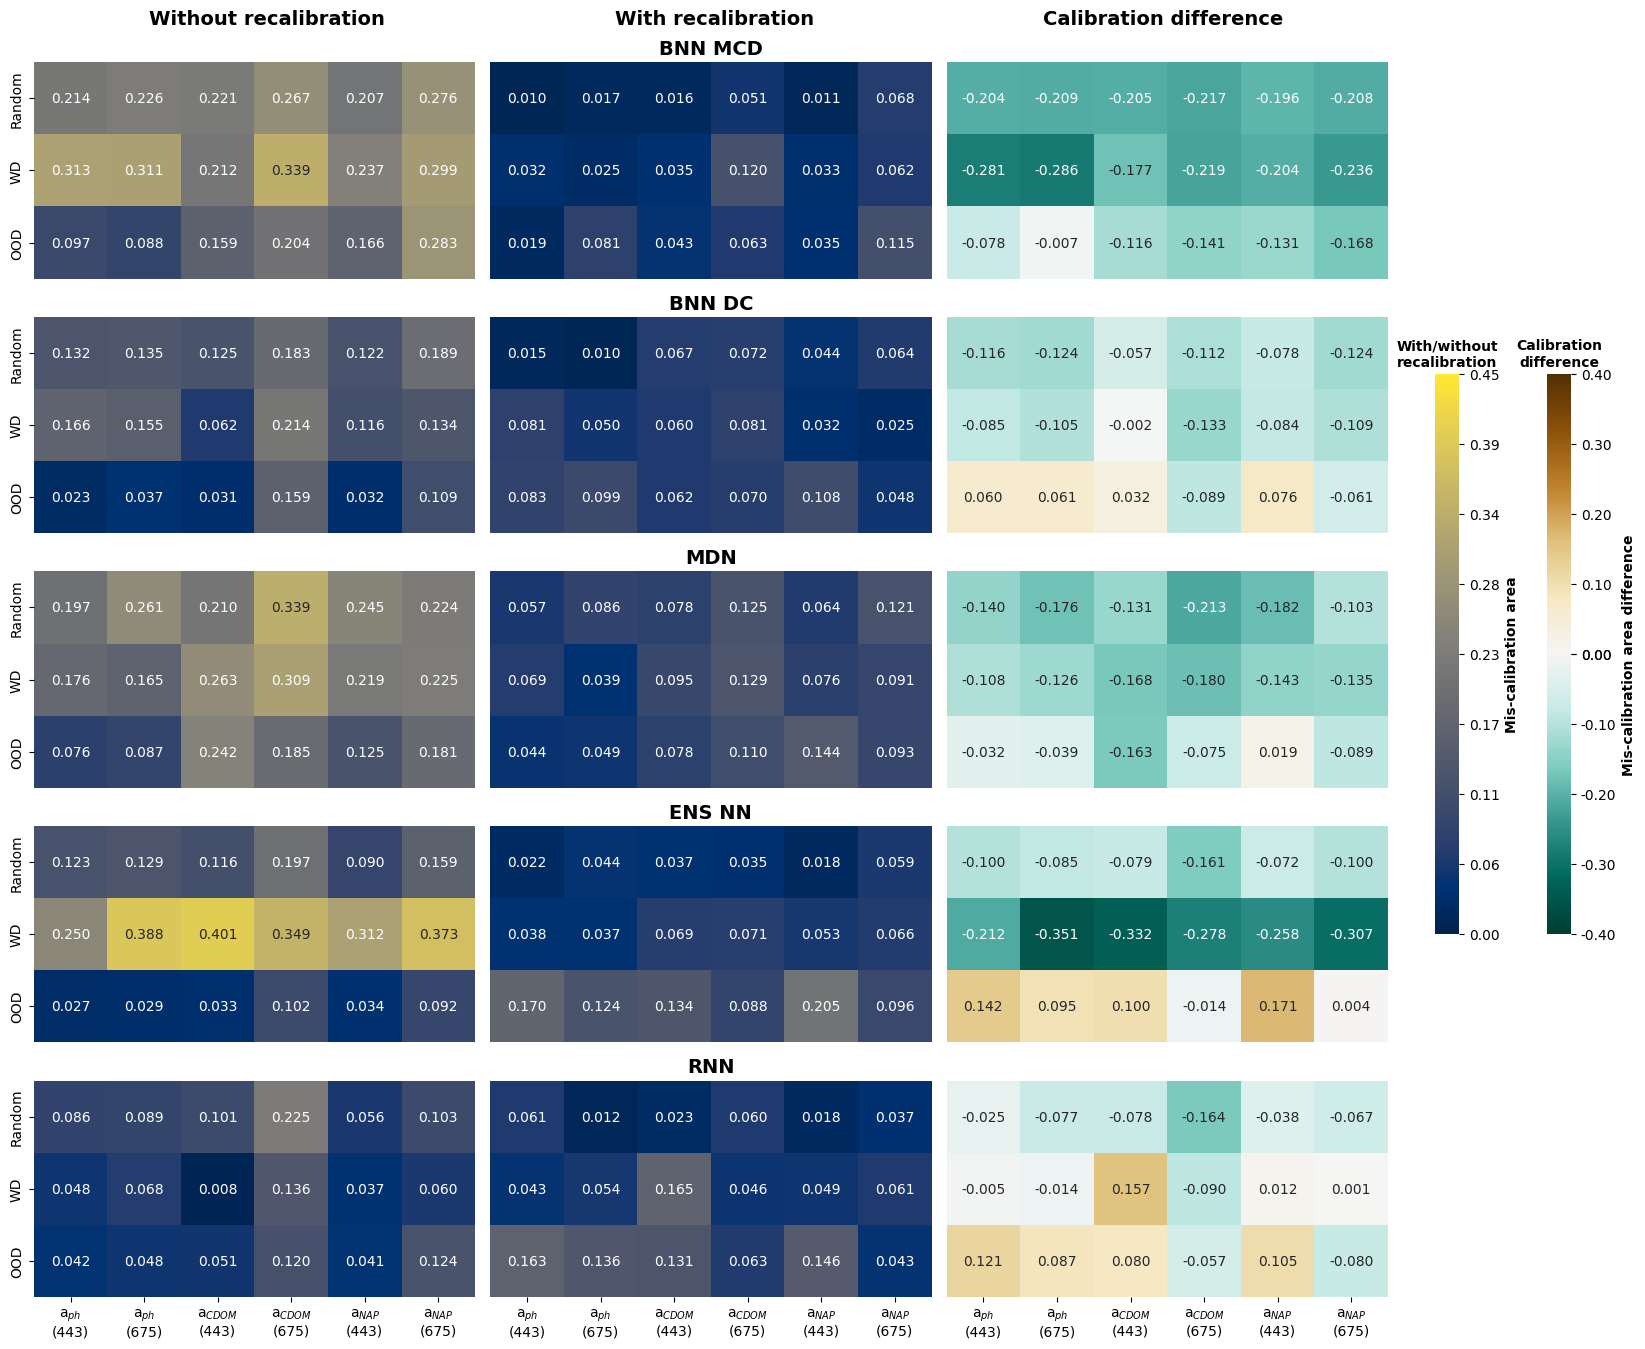

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# data
models = ['bnn_mcd', 'bnn_dc', 'mdn', 'ens_nn', 'rnn']
scenarios = ['Random', 'WD', 'OOD']
variables = ['aph_443', 'aph_675', 'aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675']
variables_formatted = ['a$_{ph}$\n(443)', 'a$_{ph}$\n(675)', 'a$_{CDOM}$\n(443)', 'a$_{CDOM}$\n(675)', 'a$_{NAP}$\n(443)', 'a$_{NAP}$\n(675)']
model_file_mapping = {
    'BNN MCD': 'bnn_mcd',
    'BNN DC': 'bnn_dc',
    'MDN': 'mdn',
    'ENS NN': 'ens_nn',
    'RNN': 'rnn'
}

# def get_median_model_ma(file_path):
#     try:
#         df = pd.read_csv(file_path)
#         if 'model' not in df.columns or 'MdSA' not in df.columns:
#             print(f"Required columns not found in {file_path}")
#             return [np.nan] * len(variables)

#         # group by model and get the median MdSA
#         median_mdsa = df.groupby('model')['MdSA'].median().sort_values()
#         if len(median_mdsa) == 0:
#             print(f"No valid data found in {file_path}")
#             return [np.nan] * len(variables)

#         median_model = median_mdsa.index[len(median_mdsa) // 2]  # get the middle model
#         median_model_data = df[df['model'] == median_model]
        
#         # get MA values for each variable
#         ma_values = []
#         for var in variables:
#             var_data = median_model_data[median_model_data['variable'] == var]
#             if len(var_data) > 0:
#                 ma_values.append(var_data['MA'].iloc[0])
#             else:
#                 ma_values.append(np.nan)
#         return ma_values
    
#     except Exception as e:
#         print(f"Error processing {file_path}: {str(e)}")
#         return [np.nan] * len(variables)

def get_median_model_ma(file_path):
    try:
        df = pd.read_csv(file_path)
        if 'model' not in df.columns or 'variable' not in df.columns or 'MdSA' not in df.columns:
            print(f"Required columns not found in {file_path}")
            return [np.nan] * len(variables)
        
        # filter for only the 443 nm variables
        vars_443 = ['aph_443', 'aCDOM_443', 'aNAP_443']
        df_443 = df[df['variable'].isin(vars_443)]
        
        # calculate the median MdSA across the 443 nm variables for each model
        median_mdsa_443 = df_443.groupby('model')['MdSA'].median().sort_values()
        
        if len(median_mdsa_443) == 0:
            print(f"No valid data found in {file_path}")
            return [np.nan] * len(variables)
        
        # select the median model
        median_model = median_mdsa_443.index[len(median_mdsa_443) // 2]
        
        # get MA values for all variables for the median model
        ma_values = []
        for var in variables:
            var_data = df[(df['model'] == median_model) & (df['variable'] == var)]
            if len(var_data) > 0:
                ma_values.append(var_data['MA'].iloc[0])
            else:
                ma_values.append(np.nan)
        
        return ma_values
   
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return [np.nan] * len(variables)

def process_data(base_path):
    # before/without recal
    # after/with recal
    before_data = np.zeros((len(models), len(scenarios), len(variables)))
    after_data = np.zeros((len(models), len(scenarios), len(variables)))

    for i, model in enumerate(models):
        for j, scenario in enumerate(scenarios):
            before_file = os.path.join(base_path, f'{model}_{scenario}_split_metrics.csv')
            after_file = os.path.join(base_path, f'{model}_{scenario}_split_recal_metrics.csv')
            
            if not os.path.exists(before_file):
                print(f"File not found: {before_file}")
                before_data[i, j] = [np.nan] * len(variables)
            else:
                before_data[i, j] = get_median_model_ma(before_file)
            
            if not os.path.exists(after_file):
                print(f"File not found: {after_file}")
                after_data[i, j] = [np.nan] * len(variables)
            else:
                after_data[i, j] = get_median_model_ma(after_file)

    return before_data, after_data

# process the datasets
base_path = r'C:\SwitchDrive\Data\pnn_model_estimates'
before_data, after_data = process_data(base_path)
# change/difference 
change_data = after_data - before_data

def plot_heatmap(data, ax, title, cmap, vmin, vmax, center=None, cbar_ax=None, ylabel=True, xlabel=False):
    sns.heatmap(data, ax=ax, cmap=cmap, annot=True, fmt='.3f', 
                xticklabels=variables_formatted if xlabel else False, 
                yticklabels=scenarios if ylabel else False, 
                cbar=cbar_ax is not None, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, center=center)
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold')
    if xlabel:
        ax.set_xticks(np.arange(len(variables)) + 0.5)
        ax.set_xticklabels(variables_formatted)
    ax.set_xlabel('')
    if not ylabel:
        ax.set_ylabel('')

# start the plotting here
fig, axs = plt.subplots(5, 3, figsize=(16, 14))

# calculate global min and max for consistent color scaling
#global_min = np.nanmin([np.nanmin(before_data), np.nanmin(after_data)])
#global_max = np.nanmax([np.nanmax(before_data), np.nanmax(after_data)])
#change_abs_max = np.nanmax([abs(np.nanmin(change_data)), abs(np.nanmax(change_data))])

# tick ranges
ticks_before_after = np.linspace(0, 0.45, 9)
ticks_change = np.linspace(-0.4, 0.4, 9)
# add a zero to the difference cbar
ticks_change = np.append(ticks_change, 0)
ticks_change = np.sort(ticks_change)

# cbars positioning
cbar_before_after = fig.add_axes([0.9, 0.3, 0.015, 0.4])
cbar_change = fig.add_axes([0.97, 0.3, 0.015, 0.4])

for i, model in enumerate(models):
    display_name = [name for name, file in model_file_mapping.items() if file == model][0]
    plot_heatmap(before_data[i], axs[i, 0], None, 'cividis', 0, 0.45, cbar_ax=cbar_before_after if i == 0 else None)
    plot_heatmap(after_data[i], axs[i, 1], display_name if i == 0 else None, 'cividis', 0, 0.45, ylabel=False)
    plot_heatmap(change_data[i], axs[i, 2], None, 'BrBG_r', -0.4, 0.4, center=0, cbar_ax=cbar_change if i == 0 else None, ylabel=False)
    if i < 4:  # remove x-axis labels but for last row
        for j in range(3):
            axs[i, j].set_xticklabels([])

    if i == 4:  # x-axis labels just for the last row
        for j in range(3):
            axs[i, j].set_xticks(np.arange(len(variables)) + 0.5)
            axs[i, j].set_xticklabels(variables_formatted)

    # model title to the middle column of each row
    axs[i, 1].set_title(display_name, fontsize=14, fontweight='bold')

# adjustments colorbar ticks and labels
cbar_before_after.set_ylabel('Mis-calibration area', fontsize=10, fontweight='bold')
cbar_before_after.set_title('With/without\nrecalibration', fontsize=10, fontweight='bold')
cbar_before_after.yaxis.set_ticks(ticks_before_after)
cbar_before_after.yaxis.set_ticklabels([f'{x:.2f}' for x in ticks_before_after])

cbar_change.set_ylabel('Mis-calibration area difference', fontsize=10, fontweight='bold')
cbar_change.set_title('Calibration\ndifference', fontsize=10, fontweight='bold')
cbar_change.yaxis.set_ticks(ticks_change)
cbar_change.yaxis.set_ticklabels([f'{x:.2f}' for x in ticks_change])

# titles for the three columns
fig.text(0.17, 0.95, 'Without recalibration', ha='center', fontsize=14, fontweight='bold')
fig.text(0.45, 0.95, 'With recalibration', ha='center', fontsize=14, fontweight='bold')
fig.text(0.73, 0.95, 'Calibration difference', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.88, 0.95])
#plt.savefig('C:/SwitchDrive/Data/Plots/miscalibration_s1-3.pdf',dpi=300,bbox_inches='tight')
plt.show()


In [100]:
# get the heatmap data for stats analysis

# flatten the first two dimensions and keep the third dimension
flattened_2d_array = change_data.reshape(-1, change_data.shape[2])
rounded_2d_array = np.round(flattened_2d_array, 3)

# display the result - copy and use as the heatmap data; hardcoded
rounded_2d_array.tolist()


[[-0.204, -0.209, -0.205, -0.217, -0.196, -0.208],
 [-0.281, -0.286, -0.177, -0.219, -0.204, -0.236],
 [-0.078, -0.007, -0.116, -0.141, -0.131, -0.168],
 [-0.116, -0.124, -0.057, -0.112, -0.078, -0.124],
 [-0.085, -0.105, -0.002, -0.133, -0.084, -0.109],
 [0.06, 0.061, 0.032, -0.089, 0.076, -0.061],
 [-0.14, -0.176, -0.131, -0.213, -0.182, -0.103],
 [-0.108, -0.126, -0.168, -0.18, -0.143, -0.135],
 [-0.032, -0.039, -0.163, -0.075, 0.019, -0.089],
 [-0.1, -0.085, -0.079, -0.161, -0.072, -0.1],
 [-0.212, -0.351, -0.332, -0.278, -0.258, -0.307],
 [0.142, 0.095, 0.1, -0.014, 0.171, 0.004],
 [-0.025, -0.077, -0.078, -0.164, -0.038, -0.067],
 [-0.005, -0.014, 0.157, -0.09, 0.012, 0.001],
 [0.121, 0.087, 0.08, -0.057, 0.105, -0.08]]

In [ ]:
### Adjusted for PRISMA

C:\Users\werthemo\AppData\Local\Temp\ipykernel_27872\703094708.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.95])


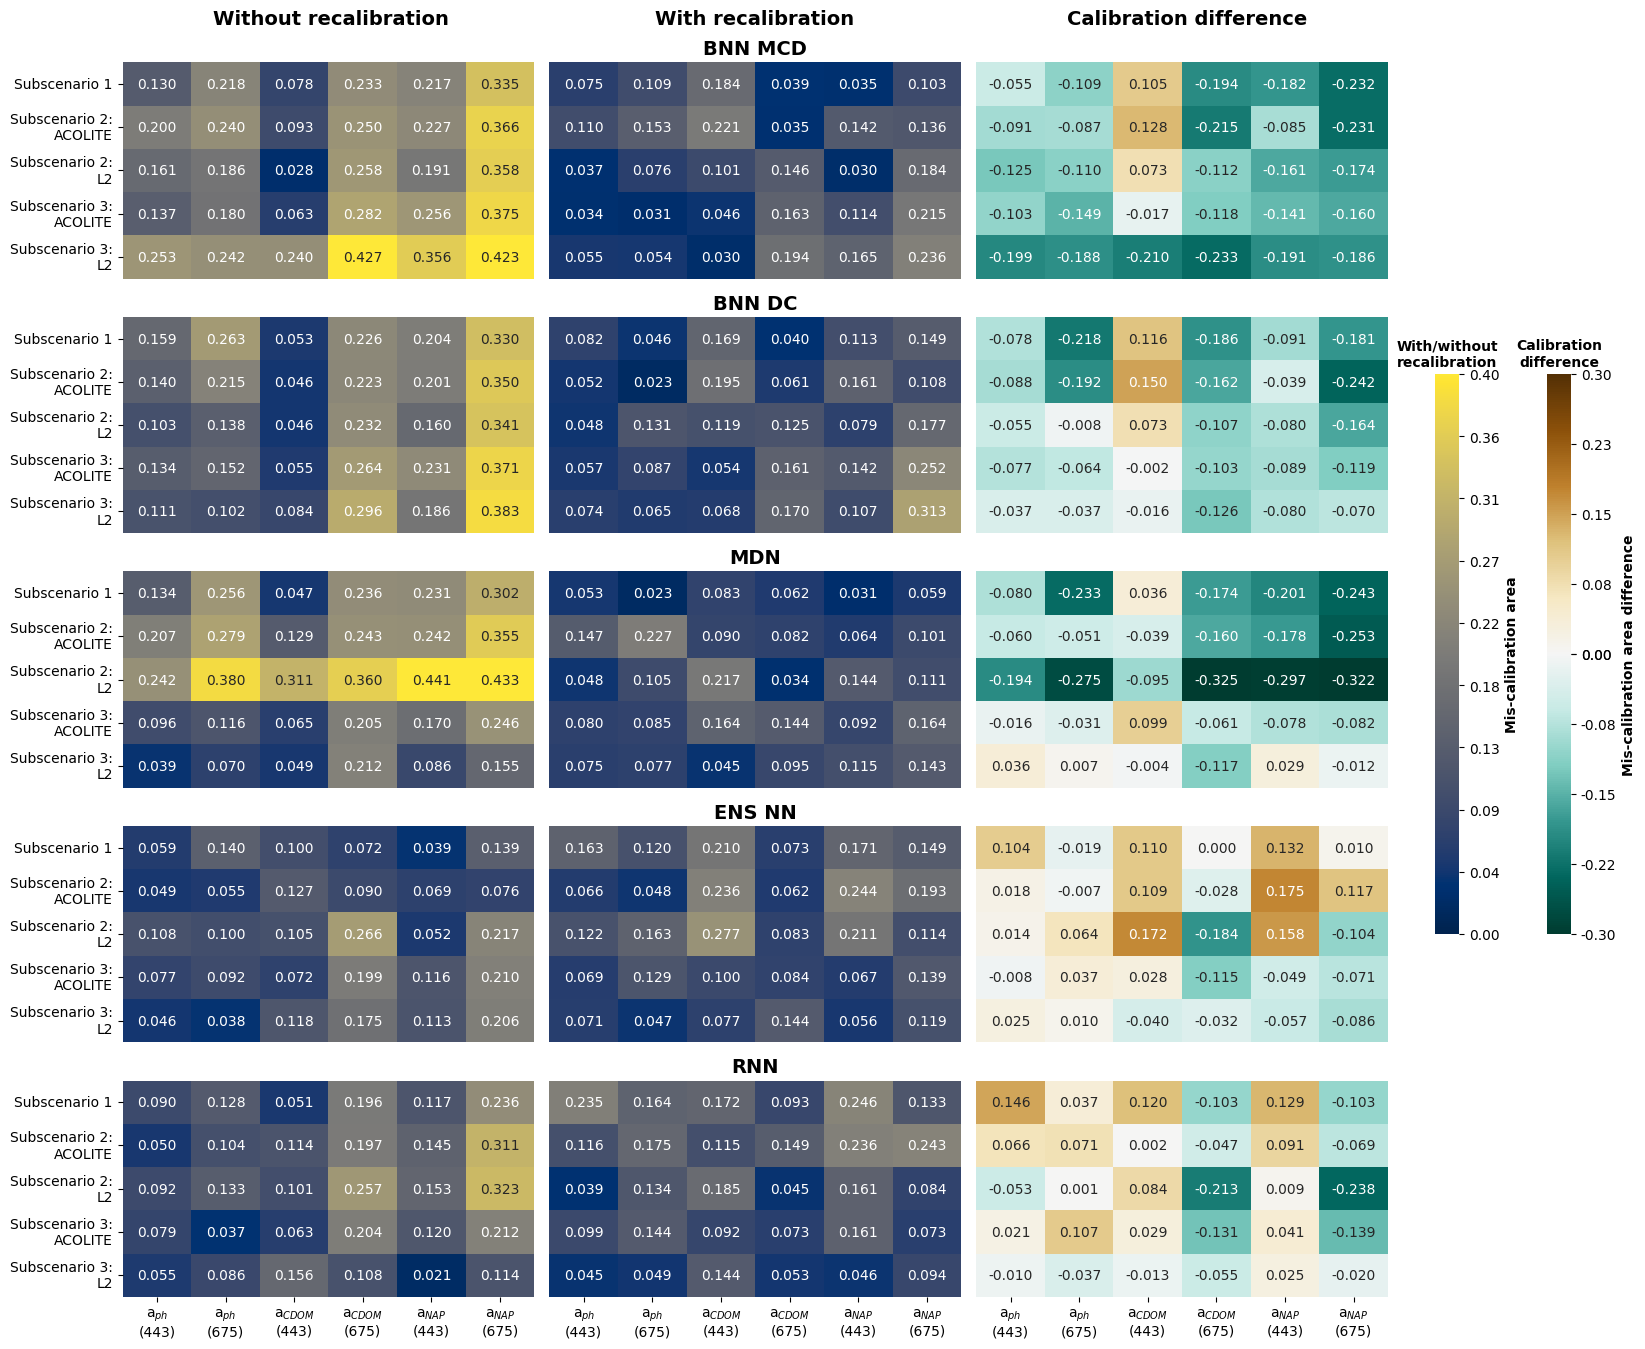

In [96]:
# Dupdated variables
models = ['bnn_mcd', 'bnn_dc', 'mdn', 'ens_nn', 'rnn']
scenarios = ['prisma_1', 'prisma_ood_a', 'prisma_ood_l', 'prisma_wd_a', 'prisma_wd_l']
new_y_labels = ['Subscenario 1', 'Subscenario 2:\nACOLITE', 'Subscenario 2:\nL2', 'Subscenario 3:\nACOLITE', 'Subscenario 3:\nL2']
variables = ['aph_443', 'aph_675', 'aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675']
variables_formatted = ['a$_{ph}$\n(443)', 'a$_{ph}$\n(675)', 'a$_{CDOM}$\n(443)', 'a$_{CDOM}$\n(675)', 'a$_{NAP}$\n(443)', 'a$_{NAP}$\n(675)']
model_file_mapping = {
    'BNN MCD': 'bnn_mcd',
    'BNN DC': 'bnn_dc',
    'MDN': 'mdn',
    'ENS NN': 'ens_nn',
    'RNN': 'rnn'
}

# def get_median_model_ma(file_path):
#     try:
#         df = pd.read_csv(file_path)
#         if 'model' not in df.columns or 'MdSA' not in df.columns:
#             return [np.nan] * len(variables)

#         median_mdsa = df.groupby('model')['MdSA'].median().sort_values()
#         if len(median_mdsa) == 0:
#             return [np.nan] * len(variables)

#         median_model = median_mdsa.index[len(median_mdsa) // 2]
#         median_model_data = df[df['model'] == median_model]
        
#         ma_values = []
#         for var in variables:
#             var_data = median_model_data[median_model_data['variable'] == var]
#             if len(var_data) > 0:
#                 ma_values.append(var_data['MA'].iloc[0])
#             else:
#                 ma_values.append(np.nan)
        
#         return ma_values
#     except Exception as e:
#         return [np.nan] * len(variables)

def get_median_model_ma(file_path):
    try:
        df = pd.read_csv(file_path)
        if 'model' not in df.columns or 'variable' not in df.columns or 'MdSA' not in df.columns:
            print(f"Required columns not found in {file_path}")
            return [np.nan] * len(variables)
        
        # Filter for only the 443 nm variables
        vars_443 = ['aph_443', 'aCDOM_443', 'aNAP_443']
        df_443 = df[df['variable'].isin(vars_443)]
        
        # Calculate the median MdSA across the 443 nm variables for each model
        median_mdsa_443 = df_443.groupby('model')['MdSA'].sum().sort_values()
        
        if len(median_mdsa_443) == 0:
            print(f"No valid data found in {file_path}")
            return [np.nan] * len(variables)
        
        # Select the median model
        median_model = median_mdsa_443.index[len(median_mdsa_443) // 2]
        
        # Get MA values for all variables for the median model
        ma_values = []
        for var in variables:
            var_data = df[(df['model'] == median_model) & (df['variable'] == var)]
            if len(var_data) > 0:
                ma_values.append(var_data['MA'].iloc[0])
            else:
                ma_values.append(np.nan)
        
        return ma_values
   
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return [np.nan] * len(variables)

def process_data(base_path):
    before_data = np.zeros((len(models), len(scenarios), len(variables)))
    after_data = np.zeros((len(models), len(scenarios), len(variables)))

    for i, model in enumerate(models):
        for j, scenario in enumerate(scenarios):
            before_file = os.path.join(base_path, f'{model}_{scenario}_metrics.csv')
            after_file = os.path.join(base_path, f'{model}_{scenario}_recal_metrics.csv')
            
            if not os.path.exists(before_file):
                before_data[i, j] = [np.nan] * len(variables)
            else:
                before_data[i, j] = get_median_model_ma(before_file)
            
            if not os.path.exists(after_file):
                after_data[i, j] = [np.nan] * len(variables)
            else:
                after_data[i, j] = get_median_model_ma(after_file)

    return before_data, after_data

# process
base_path = r'C:\SwitchDrive\Data\pnn_model_estimates'
before_data, after_data = process_data(base_path)
change_data = after_data - before_data

def plot_heatmap(data, ax, title, cmap, vmin, vmax, center=None, cbar_ax=None, ylabel=True, xlabel=False):
    sns.heatmap(data, ax=ax, cmap=cmap, annot=True, fmt='.3f', 
                xticklabels=variables_formatted if xlabel else False, 
                # update:
                yticklabels=new_y_labels if ylabel else False, 
                cbar=cbar_ax is not None, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, center=center)
    if title:
        ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('')
    if not ylabel:
        ax.set_ylabel('')

fig, axs = plt.subplots(5, 3, figsize=(16, 14))

#global_min = np.nanmin([np.nanmin(before_data), np.nanmin(after_data)])
#global_max = np.nanmax([np.nanmax(before_data), np.nanmax(after_data)])
#change_abs_max = np.nanmax([abs(np.nanmin(change_data)), abs(np.nanmax(change_data))])

ticks_before_after = np.linspace(0, 0.4, 10)
ticks_change = np.linspace(-0.3, 0.3, 9)
ticks_change = np.append(ticks_change, 0)
ticks_change = np.sort(ticks_change)

cbar_before_after = fig.add_axes([0.9, 0.3, 0.015, 0.4])
cbar_change = fig.add_axes([0.97, 0.3, 0.015, 0.4])

for i, model in enumerate(models):
    display_name = [name for name, file in model_file_mapping.items() if file == model][0]
    plot_heatmap(before_data[i], axs[i, 0], None, 'cividis', 0, 0.4, cbar_ax=cbar_before_after if i == 0 else None)
    plot_heatmap(after_data[i], axs[i, 1], display_name if i == 0 else None, 'cividis', 0, 0.45, ylabel=False)
    plot_heatmap(change_data[i], axs[i, 2], None, 'BrBG_r', -0.3, 0.3, center=0, cbar_ax=cbar_change if i == 0 else None, ylabel=False)
    if i < 4:
        for j in range(3):
            axs[i, j].set_xticklabels([])

    if i == 4:
        for j in range(3):
            axs[i, j].set_xticks(np.arange(len(variables)) + 0.5)
            axs[i, j].set_xticklabels(variables_formatted)

    axs[i, 1].set_title(display_name, fontsize=14, fontweight='bold')

cbar_before_after.set_ylabel('Mis-calibration area', fontsize=10, fontweight='bold')
cbar_before_after.set_title('With/without\nrecalibration', fontsize=10, fontweight='bold')
cbar_before_after.yaxis.set_ticks(ticks_before_after)
cbar_before_after.yaxis.set_ticklabels([f'{x:.2f}' for x in ticks_before_after])
# somehow shows no effect, not sure how to have the extend='max' active
cbar_before_after.extend = 'max'

cbar_change.set_ylabel('Mis-calibration area difference', fontsize=10, fontweight='bold')
cbar_change.set_title('Calibration\ndifference', fontsize=10, fontweight='bold')
cbar_change.yaxis.set_ticks(ticks_change)
cbar_change.yaxis.set_ticklabels([f'{x:.2f}' for x in ticks_change])

fig.text(0.21, 0.95, 'Without recalibration', ha='center', fontsize=14, fontweight='bold')
fig.text(0.475, 0.95, 'With recalibration', ha='center', fontsize=14, fontweight='bold')
fig.text(0.745, 0.95, 'Calibration difference', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.88, 0.95])
#plt.savefig('C:/SwitchDrive/Data/Plots/miscalibration_prisma.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
### Analysis of the heatmaps 

In [97]:
import numpy as np

# Flatten the first two dimensions and keep the third dimension
flattened_2d_array = change_data.reshape(-1, change_data.shape[2])

# round the array to 3 decimal places
rounded_2d_array = np.round(flattened_2d_array, 3)

# display the result - copy and use as the calibration_difference heatmap data
rounded_2d_array.tolist()


[[-0.055, -0.109, 0.105, -0.194, -0.182, -0.232],
 [-0.091, -0.087, 0.128, -0.215, -0.085, -0.231],
 [-0.125, -0.11, 0.073, -0.112, -0.161, -0.174],
 [-0.103, -0.149, -0.017, -0.118, -0.141, -0.16],
 [-0.199, -0.188, -0.21, -0.233, -0.191, -0.186],
 [-0.078, -0.218, 0.116, -0.186, -0.091, -0.181],
 [-0.088, -0.192, 0.15, -0.162, -0.039, -0.242],
 [-0.055, -0.008, 0.073, -0.107, -0.08, -0.164],
 [-0.077, -0.064, -0.002, -0.103, -0.089, -0.119],
 [-0.037, -0.037, -0.016, -0.126, -0.08, -0.07],
 [-0.08, -0.233, 0.036, -0.174, -0.201, -0.243],
 [-0.06, -0.051, -0.039, -0.16, -0.178, -0.253],
 [-0.194, -0.275, -0.095, -0.325, -0.297, -0.322],
 [-0.016, -0.031, 0.099, -0.061, -0.078, -0.082],
 [0.036, 0.007, -0.004, -0.117, 0.029, -0.012],
 [0.104, -0.019, 0.11, 0.0, 0.132, 0.01],
 [0.018, -0.007, 0.109, -0.028, 0.175, 0.117],
 [0.014, 0.064, 0.172, -0.184, 0.158, -0.104],
 [-0.008, 0.037, 0.028, -0.115, -0.049, -0.071],
 [0.025, 0.01, -0.04, -0.032, -0.057, -0.086],
 [0.146, 0.037, 0.12, -0

In [98]:
# calibration difference values for PRISMA subscenarios
calibration_diff = [
 [-0.055, -0.109, 0.105, -0.194, -0.182, -0.232],
 [-0.091, -0.087, 0.128, -0.215, -0.085, -0.231],
 [-0.125, -0.11, 0.073, -0.112, -0.161, -0.174],
 [-0.103, -0.149, -0.017, -0.118, -0.141, -0.16],
 [-0.199, -0.188, -0.21, -0.233, -0.191, -0.186],
 [-0.078, -0.218, 0.116, -0.186, -0.091, -0.181],
 [-0.088, -0.192, 0.15, -0.162, -0.039, -0.242],
 [-0.055, -0.008, 0.073, -0.107, -0.08, -0.164],
 [-0.077, -0.064, -0.002, -0.103, -0.089, -0.119],
 [-0.037, -0.037, -0.016, -0.126, -0.08, -0.07],
 [-0.08, -0.233, 0.036, -0.174, -0.201, -0.243],
 [-0.06, -0.051, -0.039, -0.16, -0.178, -0.253],
 [-0.194, -0.275, -0.095, -0.325, -0.297, -0.322],
 [-0.016, -0.031, 0.099, -0.061, -0.078, -0.082],
 [0.036, 0.007, -0.004, -0.117, 0.029, -0.012],
 [0.104, -0.019, 0.11, 0.0, 0.132, 0.01],
 [0.018, -0.007, 0.109, -0.028, 0.175, 0.117],
 [0.014, 0.064, 0.172, -0.184, 0.158, -0.104],
 [-0.008, 0.037, 0.028, -0.115, -0.049, -0.071],
 [0.025, 0.01, -0.04, -0.032, -0.057, -0.086],
 [0.146, 0.037, 0.12, -0.103, 0.129, -0.103],
 [0.066, 0.071, 0.002, -0.047, 0.091, -0.069],
 [-0.053, 0.001, 0.084, -0.213, 0.009, -0.238],
 [0.021, 0.107, 0.029, -0.131, 0.041, -0.139],
 [-0.01, -0.037, -0.013, -0.055, 0.025, -0.02]
 ]

def analyze_subset(data, subscenario, method):
    flat_data = [item for sublist in data for item in sublist]
    # negative differences are beneficial recalibrations
    beneficial_recalibrations = [x for x in flat_data if x < 0]
    # how many are beneficial
    count_beneficial = len(beneficial_recalibrations)
    total_improvement = sum(beneficial_recalibrations)
    # what's the average improvement through recal if effective
    average_improvement = total_improvement / count_beneficial if count_beneficial > 0 else 0
    # and the median
    median_improvement = np.median(beneficial_recalibrations) if count_beneficial > 0 else 0
    total_cases = len(flat_data)
    # percent beneficial
    percentage_beneficial = (count_beneficial / total_cases) * 100
    print(f"Subscenario {subscenario} - {method}:")
    print(f"Number of cases where recalibration was beneficial: {count_beneficial}")
    print(f"Average improvement when beneficial: {average_improvement:.4f}")
    print(f"Median improvement when beneficial: {median_improvement:.4f}")
    print(f"Percentage of cases where recalibration was beneficial: {percentage_beneficial:.2f}%")
    print("\n")

# subscenario 1 (rows 1, 6, 11, 16, 21)
subscenario_1 = [calibration_diff[i] for i in [0, 5, 10, 15, 20]]
analyze_subset(subscenario_1, 1, "All")

# subscenario 2 ACOLITE (rows 2, 7, 12, 17, 22)
subscenario_2_acolite = [calibration_diff[i] for i in [1, 6, 11, 16, 21]]
analyze_subset(subscenario_2_acolite, 2, "ACOLITE")

# subscenario 2 L2 (rows 3, 8, 13, 18, 23)
subscenario_2_l2 = [calibration_diff[i] for i in [2, 7, 12, 17, 22]]
analyze_subset(subscenario_2_l2, 2, "L2")

# subscenario 3 ACOLITE (rows 4, 9, 14, 19, 24)
subscenario_3_acolite = [calibration_diff[i] for i in [3, 8, 13, 18, 23]]
analyze_subset(subscenario_3_acolite, 3, "ACOLITE")

# subscenario 3 L2 (rows 5, 10, 15, 20, 25)
subscenario_3_l2 = [calibration_diff[i] for i in [4, 9, 14, 19, 24]]
analyze_subset(subscenario_3_l2, 3, "L2")

Subscenario 1 - All:
Number of cases where recalibration was beneficial: 18
Average improvement when beneficial: -0.1490
Median improvement when beneficial: -0.1775
Percentage of cases where recalibration was beneficial: 60.00%


Subscenario 2 - ACOLITE:
Number of cases where recalibration was beneficial: 20
Average improvement when beneficial: -0.1162
Median improvement when beneficial: -0.0875
Percentage of cases where recalibration was beneficial: 66.67%


Subscenario 2 - L2:
Number of cases where recalibration was beneficial: 21
Average improvement when beneficial: -0.1617
Median improvement when beneficial: -0.1610
Percentage of cases where recalibration was beneficial: 70.00%


Subscenario 3 - ACOLITE:
Number of cases where recalibration was beneficial: 23
Average improvement when beneficial: -0.0836
Median improvement when beneficial: -0.0820
Percentage of cases where recalibration was beneficial: 76.67%


Subscenario 3 - L2:
Number of cases where recalibration was beneficial: 2

In [101]:
import numpy as np

def extract_data(heatmap, row_indices):
    return [heatmap[i] for i in row_indices]

def analyze_subset(data, scenario):
    flat_data = [item for sublist in data for item in sublist]
    beneficial_recalibrations = [x for x in flat_data if x < 0]
    count_beneficial = len(beneficial_recalibrations)
    total_improvement = sum(beneficial_recalibrations)
    average_improvement = total_improvement / count_beneficial if count_beneficial > 0 else 0
    median_improvement = np.median(beneficial_recalibrations) if count_beneficial > 0 else 0
    total_cases = len(flat_data)
    percentage_beneficial = (count_beneficial / total_cases) * 100

    return {
        "scenario": scenario,
        "count_beneficial": count_beneficial,
        "average_improvement": average_improvement,
        "median_improvement": median_improvement,
        "percentage_beneficial": percentage_beneficial,
    }

# scenarios 1-3
# heatmap = [
#     [-0.159, -0.183, -0.162, -0.208, -0.163, -0.167],
#     [-0.219, -0.227, -0.126, -0.208, -0.144, -0.154],
#     [-0.062, -0.030, -0.094, -0.129, -0.045, -0.252],
#     [-0.108, -0.121, -0.108, -0.142, -0.096, -0.128],
#     [-0.157, -0.123, -0.037, -0.140, -0.078, -0.117],
#     [0.062, 0.058, 0.042, -0.041, 0.051, -0.046],
#     [-0.164, -0.177, -0.149, -0.248, -0.155, -0.103],
#     [-0.108, -0.126, -0.168, -0.180, -0.143, -0.135],
#     [0.036, 0.032, -0.090, -0.073, 0.095, -0.148],
#     [-0.101, -0.081, -0.080, -0.154, -0.055, -0.079],
#     [-0.264, -0.232, -0.361, -0.316, -0.242, -0.334],
#     [0.150, 0.096, 0.093, 0.034, 0.162, 0.035],
#     [-0.038, -0.054, -0.008, -0.138, -0.053, -0.042],
#     [0.041, -0.016, 0.088, -0.128, 0.005, 0.032],
#     [0.083, 0.043, -0.025, -0.073, 0.138, -0.025]
# ]

heatmap = [
 [-0.204, -0.209, -0.205, -0.217, -0.196, -0.208],
 [-0.281, -0.286, -0.177, -0.219, -0.204, -0.236],
 [-0.078, -0.007, -0.116, -0.141, -0.131, -0.168],
 [-0.116, -0.124, -0.057, -0.112, -0.078, -0.124],
 [-0.085, -0.105, -0.002, -0.133, -0.084, -0.109],
 [0.06, 0.061, 0.032, -0.089, 0.076, -0.061],
 [-0.14, -0.176, -0.131, -0.213, -0.182, -0.103],
 [-0.108, -0.126, -0.168, -0.18, -0.143, -0.135],
 [-0.032, -0.039, -0.163, -0.075, 0.019, -0.089],
 [-0.1, -0.085, -0.079, -0.161, -0.072, -0.1],
 [-0.212, -0.351, -0.332, -0.278, -0.258, -0.307],
 [0.142, 0.095, 0.1, -0.014, 0.171, 0.004],
 [-0.025, -0.077, -0.078, -0.164, -0.038, -0.067],
 [-0.005, -0.014, 0.157, -0.09, 0.012, 0.001],
 [0.121, 0.087, 0.08, -0.057, 0.105, -0.08]
 ]

# run
random_data = extract_data(heatmap, [0, 3, 6, 9, 12])
wd_data = extract_data(heatmap, [1, 4, 7, 10, 13])
ood_data = extract_data(heatmap, [2, 5, 8, 11, 14])

results = []
for scenario, data in [("Random", random_data), ("WD", wd_data), ("OOD", ood_data)]:
    results.append(analyze_subset(data, scenario))

# print outcomes
for result in results:
    print(f"Scenario: {result['scenario']}")
    print(f"Number of cases where recalibration was beneficial: {result['count_beneficial']}")
    print(f"Average improvement when beneficial: {result['average_improvement']:.4f}")
    print(f"Median improvement when beneficial: {result['median_improvement']:.4f}")
    print(f"Percentage of cases where recalibration was beneficial: {result['percentage_beneficial']:.2f}%")
    print("\n")

Scenario: Random
Number of cases where recalibration was beneficial: 30
Average improvement when beneficial: -0.1280
Median improvement when beneficial: -0.1200
Percentage of cases where recalibration was beneficial: 100.00%


Scenario: WD
Number of cases where recalibration was beneficial: 27
Average improvement when beneficial: -0.1714
Median improvement when beneficial: -0.1680
Percentage of cases where recalibration was beneficial: 90.00%


Scenario: OOD
Number of cases where recalibration was beneficial: 16
Average improvement when beneficial: -0.0837
Median improvement when beneficial: -0.0790
Percentage of cases where recalibration was beneficial: 53.33%


